# MetPy Calculations

In [1]:
from datetime import datetime, timedelta

import metpy.calc as mpcalc
from metpy.plots.declarative import *
from metpy.units import units
import xarray as xr

In [2]:
# Set the date/time of the model run
date = datetime(2020, 5, 15, 0)

# Remote access to the dataset from the UCAR site
ds = xr.open_dataset('https://thredds.ucar.edu/thredds/dodsC/grib'
                     f'/NCEP/GFS/Global_onedeg/GFS_Global_onedeg_{date:%Y%m%d}_{date:%H%M}.grib2')

# Set the plot time with forecast hours
plot_time = date + timedelta(hours=0)

# Subset data to be just over the U.S. for plotting purposes and for the plot_time
ds = ds.metpy.sel(lat=slice(70,10), lon=slice(360-150, 360-55))

## A Simple Calculation

1000-500-hPa Thickness = (Heights at 500 hPa) - (Heights at 1000 hPa)

Easy to do subtraction with a data array and store it directly back into the dataset (ds).
                   

In [3]:
ds['thickness'] = (ds.Geopotential_height_isobaric.metpy.sel(time=plot_time, vertical=500 * units.hPa)
                   - ds.Geopotential_height_isobaric.metpy.sel(time=plot_time, vertical=1000 * units.hPa))

Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable


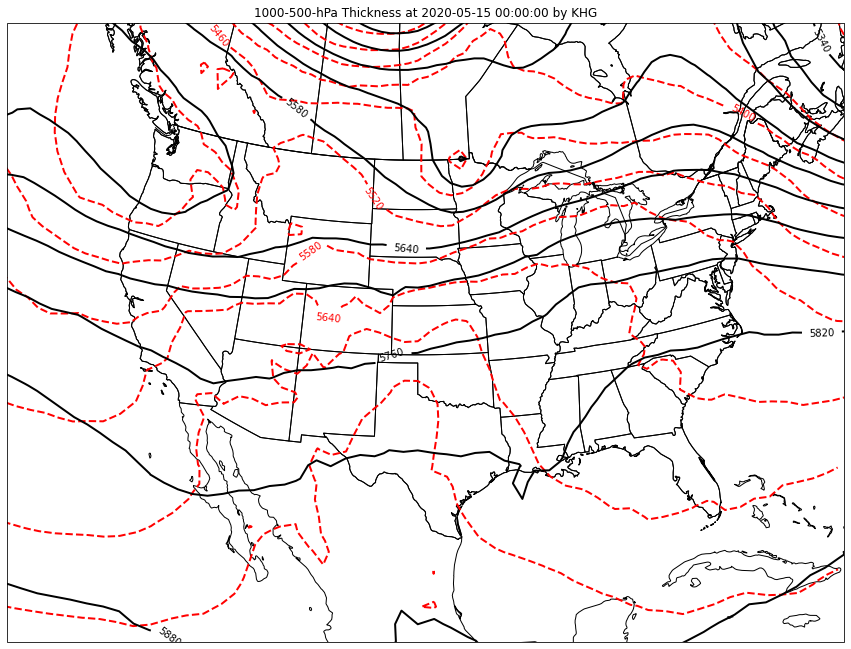

In [4]:
# Set attributes for plotting contours
cntr = ContourPlot()
cntr.data = ds
cntr.field = 'thickness'
cntr.level = None
cntr.time = None
cntr.contours = list(range(0, 10000, 60))
cntr.linecolor = 'red'
cntr.linestyle = 'dashed'
cntr.clabels = True

cntr2 = ContourPlot()
cntr2.data = ds
cntr2.field = 'Geopotential_height_isobaric'
cntr2.level = 500 * units.hPa
cntr2.time = plot_time
cntr2.contours = list(range(0, 10000, 60))
cntr2.linecolor = 'black'
cntr2.linestyle = 'solid'
cntr2.clabels = True

# Set the attributes for the map
# and put the contours on the map
panel = MapPanel()
panel.area = [-125, -74, 20, 55]
panel.projection = 'lcc'
panel.layers = ['states', 'coastline', 'borders']
panel.title = f'1000-500-hPa Thickness at {plot_time} by KHG'
panel.plots = [cntr, cntr2]

# Set the attributes for the panel
# and put the panel in the figure
pc = PanelContainer()
pc.size = (15, 15)
pc.panels = [panel]

# Show the figure
pc.show()

## A Second Simple Calculation

Scaling Absolute Vorticity

Since vorticity values are on the order of 10^-5 we want to scale them to fit common contouring values of whole numbers.

In [5]:
ds['Absolute_vorticity_isobaric'].values = ds.Absolute_vorticity_isobaric.values * 1e5

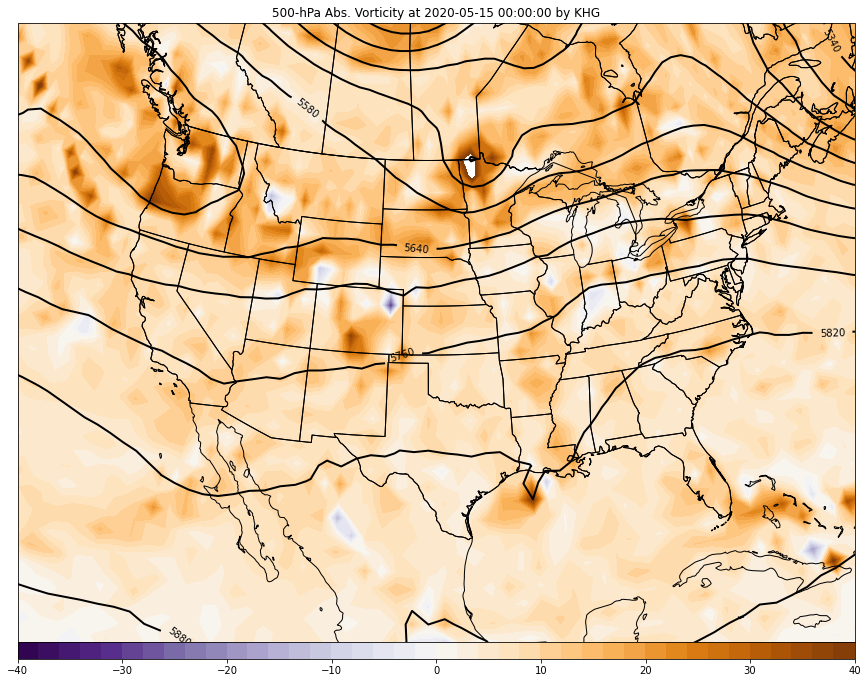

In [7]:
# Set the plot time with forecast hours
plot_time = date + timedelta(hours=0)

# Set attributes for plotting contours
cfill = FilledContourPlot()
cfill.data = ds
cfill.field = 'Absolute_vorticity_isobaric'
cfill.level = 500 * units.hPa
cfill.time = plot_time
cfill.contours = list(range(-40, 41, 2))
cfill.colormap = 'PuOr_r'
cfill.colorbar = 'horizontal'

cntr2 = ContourPlot()
cntr2.data = ds
cntr2.field = 'Geopotential_height_isobaric'
cntr2.level = 500 * units.hPa
cntr2.time = plot_time
cntr2.contours = list(range(0, 10000, 60))
cntr2.linecolor = 'black'
cntr2.linestyle = 'solid'
cntr2.clabels = True

# Set the attributes for the map
# and put the contours on the map
panel = MapPanel()
panel.area = [-125, -74, 20, 55]
panel.projection = 'lcc'
panel.layers = ['states', 'coastline', 'borders']
panel.title = f'{cfill.level.m}-hPa Abs. Vorticity at {plot_time} by KHG'
panel.plots = [cfill, cntr2]

# Set the attributes for the panel
# and put the panel in the figure
pc = PanelContainer()
pc.size = (15, 15)
pc.panels = [panel]

# Show the figure
pc.show()